# Imports

In [2]:
import pandas as pd
import numpy as np
from sklearn import model_selection as ms
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

Loading the dataset.

In [75]:
dataset = pd.read_csv('Handwritten_Data.csv')

Extracting labels and features.

In [76]:
labels = dataset.iloc[:, 0].values
features = dataset.iloc[:, 1:].values
print(len(features))
print(len(labels))
num_images = len(features)

372450
372450


Assigning the corresponding alphabet to each label.

In [77]:
ALPHABETS = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
true_labels = {i: ALPHABETS[i] for i in range(26)}

Visualising the dataset.

In [78]:
def show_img(arr):
    plt.imshow(arr.reshape(28, 28))

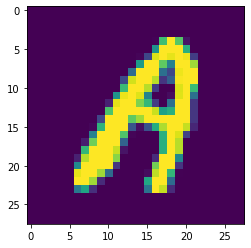

In [79]:
show_img(features[0])

Splitting the dataset.

In [80]:
X_train, X_test, y_train, y_test = ms.train_test_split(features, labels, test_size = 0.1)
print(X_test)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [81]:
len(X_train)

335205

# Training

Function to obtain P(Y = y)

In [82]:
def get_prior(y: int) -> float:
    return list(y_train).count(y) / len(y_train)

In [83]:
prior = [get_prior(y) for y in range(26)]

Function to obtain P(X<sub> i</sub> = 1 | Y = y)

In [84]:
def get_cond_prob(i: int, y: int) -> float:
    numer = 0
    denom = 0
    for u in range(len(y_train)):
        if y_train[u] == y:
            if X_train[u][i] > 127.5:
                numer += 1
            denom += 1
    return numer / denom

Class Conditional Density

P(Xi = xi | Y = k)

In [85]:
ccd = [[get_cond_prob(i, y) for i in range(784)] for y in range(26)]

Saving the prior and ccd to the file 'helper_arrays.npz'

In [86]:
np.savez('helper_arrays', prior = prior, ccd = ccd)

Loading the file containing prior and ccd.

In [87]:
outfiles = np.load('helper_arrays.npz')
outfiles.files

['prior', 'ccd']

In [88]:
prior = outfiles['prior']
ccd = outfiles['ccd']

# Testing

The preprocess function creates an array with 1's and 0's.

In [89]:
def preprocess(test_img):
    test_img1 = 784 * [0]
    for i in range(len(test_img)):
        if test_img[i] > 127.5:
            test_img1[i] = 1
        else:
            test_img1[i] = 0
    return test_img1

#### Laplace Smoothing

For every Y = y, we consider the following 2 additional images to avoid zero division error:<br>
fake_img0 = 784 * [0] <br>
fake_img1 = 784 * [1]<br>

Function to evaluate P(X<sub>i</sub> = x<sub>i</sub> | Y = y)

In [90]:
def prob_xi_given_y(feature_idx, feature, y):
    if feature == 1:
        val = ccd[y][feature_idx]  
    else:
        val = 1 - ccd[y][feature_idx]
    if val == 0:
        return 1 / (len(X_train) + 2)
    if val == 1:
        return 1 - 1 / (len(X_train) + 2)
    return val

Function to calculate continued product of conditional probabilities using the natural logarithm.

In [91]:
def calc_continued_prod(features, y):
    total = 0
    for i in range(len(features)):
        total += math.log(prob_xi_given_y(i, features[i], y))
    return math.pow(math.e, total)

Function to return the array: [P(Y = k | image) | 0 <= k <= 25 ]

In [92]:
def prob_arr(test_img):
    denom = 0
    prob = 26 * [0]
    for y in range(26):
        prob[y] = calc_continued_prod(test_img, y) * prior[y]
        denom += prob[y]
    return [prob[y] / denom for y in range(26)]

Function to make the final prediction. It returns the predicted class.

In [93]:
def get_prediction(image):
    prob_array = prob_arr(image)
    return true_labels[prob_array.index(max(prob_array))]

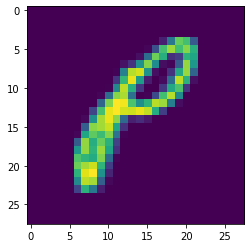

In [94]:
show_img(X_test[3])

In [95]:
test_img = preprocess(X_test[3])
true_labels[y_test[3]]

'P'

In [96]:
get_prediction(test_img)

'P'

# Performace Evaluation

In [97]:
y_true = [true_labels[y] for y in y_test]

In [98]:
y_pred = [get_prediction(preprocess(img)) for img in X_test]

Saving 2 arrays, one with actual labels, and the other with predicted labels.

In [99]:
np.savez('predictions', y_true = y_true, y_pred = y_pred)

Loading the arrays.

In [100]:
metric_file = np.load('predictions.npz')
y_true = metric_file['y_true']
y_pred = metric_file['y_pred']

Creating a confusion matrix.

In [101]:
confusion_matrix = cm(y_true, y_pred)

Visualising the confusion matrix.

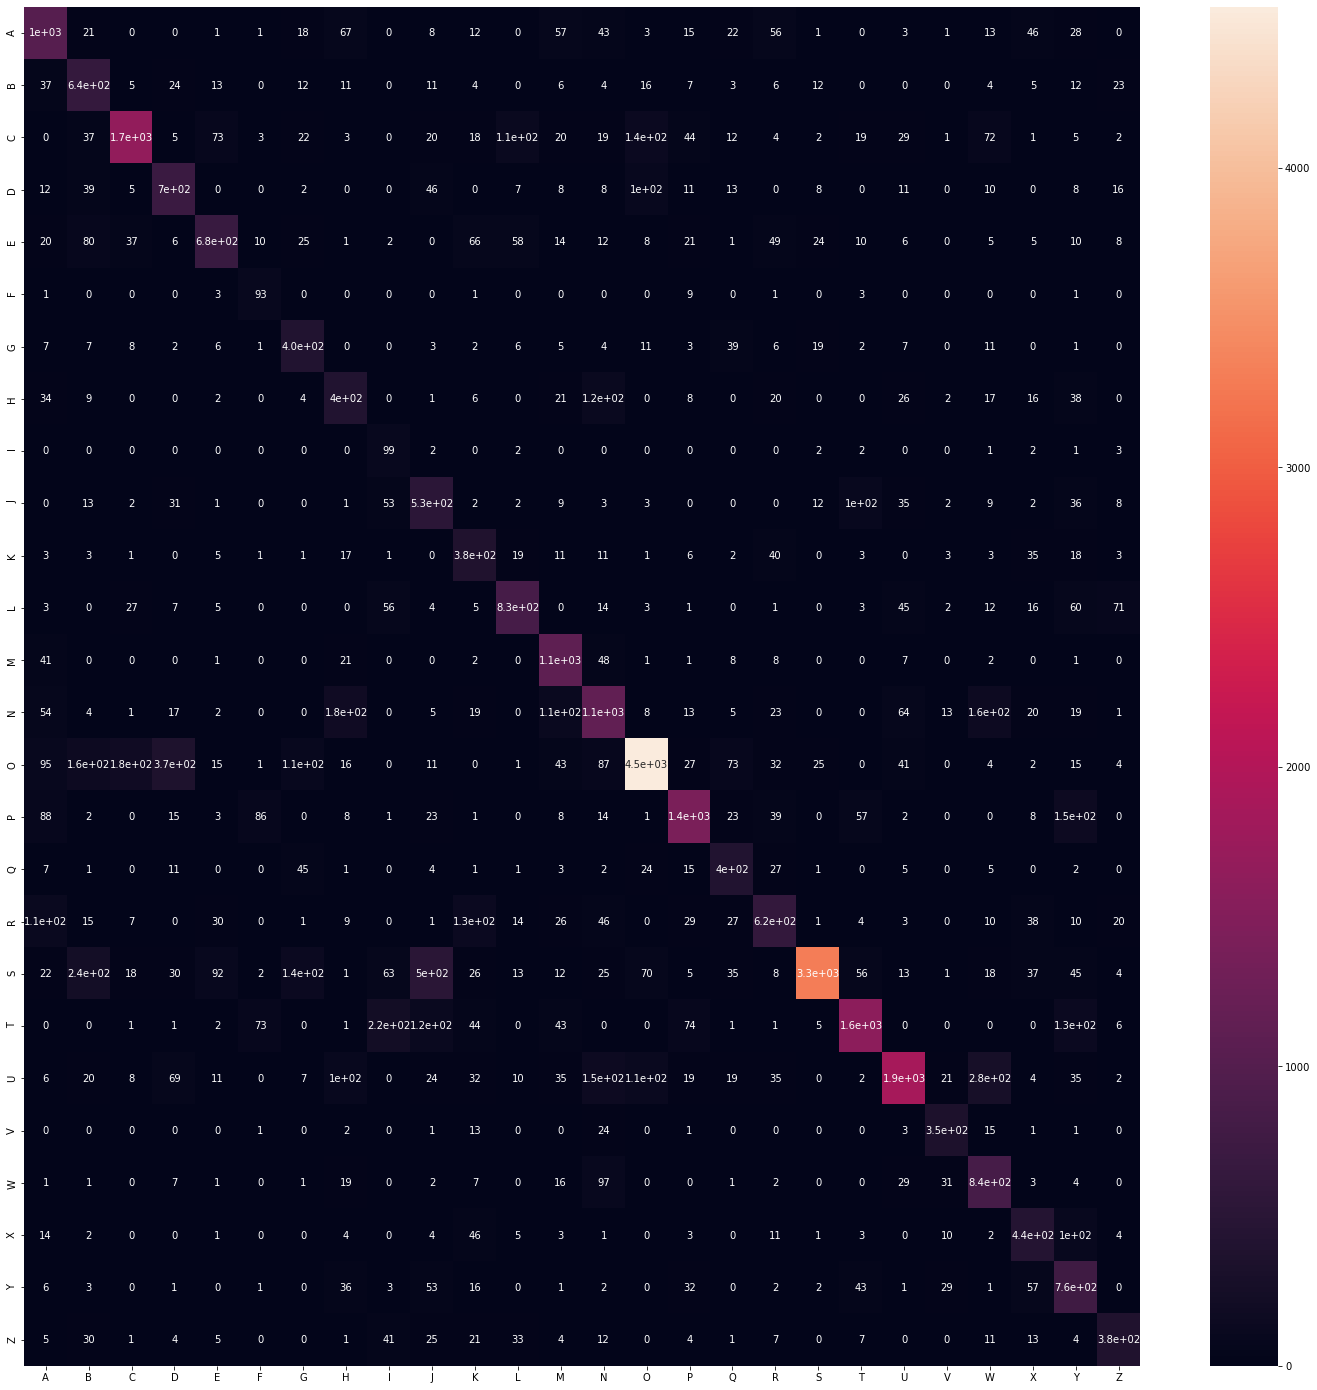

In [117]:
df_cm = pd.DataFrame(confusion_matrix, index = [i for i in ALPHABETS],
                    columns = [i for i in ALPHABETS])
fig, ax = plt.subplots(figsize=(25, 25))
heatmap = sns.heatmap(df_cm, annot = True, linewidths = 0, ax = ax)

In [103]:
accuracy = accuracy_score(y_true, y_pred, normalize = True)
accuracy

0.7035575244999329